In [6]:
'''
3. Definition of excursion:
This excursion is moreso research-based and is centered around finding a suitable programming language and
libraries to work on the project with. Our objectives are to:
  ● Develop a rough idea of the initial code for the peak detection.
  ● Research options that can feasibly work with the overall project and board.
  ● Create a simple program that can filter, refine and extract the local peaks from a given audio file.

4. Relevant Requirements and expected outcomes
This excursion will result in defining:
  ● What programming language will be used for this project.
  ● A list of possible coding libraries we’ll choose from.
  ● A more refined idea of the general code and needed methods for the algorithm.
'''

### (For Google Colab) INSTALL RELEVANT DEPENDENCIES ###

!pip install pydub
!pip install librosa
!pip install matplotlib


In [7]:
### INITIALIZE AND PLOT AUDIO ###

# Use arrays with NumPy and plotting with Matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Getting and converting audio data
from pydub import AudioSegment, effects
import wave

# Tempo finder and DSP
import librosa
from scipy.signal import butter, lfilter, freqz

# from pydub: get audio file and convert
sound = AudioSegment.from_mp3("test.mp3") # just put in like a 2 minute mp3 and rename this
# normalize, as in amplify until max peak is at max volume
sound = effects.normalize(sound)
sound.export("test.wav", format="wav") # convert to wav

# get the converted WAV and get sample rate
data = wave.open("test.wav")
fs = data.getframerate() # sample rate

# reads all the frames; -1 indicates all or max frames
signal = data.readframes(-1)
# account for buffer so data can be plotted and used correct
signal = np.frombuffer(signal, dtype ="int16")

# X axis, to display data in relation to time
secs = np.linspace(0, len(signal)/fs, num=len(signal))

# plot the input signal
plt.plot(secs, signal, color="palevioletred")
plt.title("Input Signal (After Normalization)")
plt.ylabel("Amplitude")
plt.xlabel("Time (seconds)")
plt.show()


C:\Users\saman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


FileNotFoundError: [Errno 2] No such file or directory: 'test.mp3'

In [6]:
### GET TEMPO ####

# we reload the wav file with librosa so the array is in a form librosa can understand
libData, libfs = librosa.load('test.wav')
# get the tempo of the song
BPM, beats = librosa.beat.beat_track(y=libData, sr=libfs)

# BPM output is array with 1 element, we can just turn it into an int
BPM = BPM[0]

# make sure tempo is within the range of 100 to 200 BPM
goodBPM = False
while(goodBPM == False):
  if (BPM >= 100) and (BPM <= 200):
    goodBPM = True
  if BPM >= 200:
    BPM = BPM / 2
  if BPM < 100:
    BPM = BPM * 2

print('Tempo: ', BPM)


Tempo:  166.70866935483872


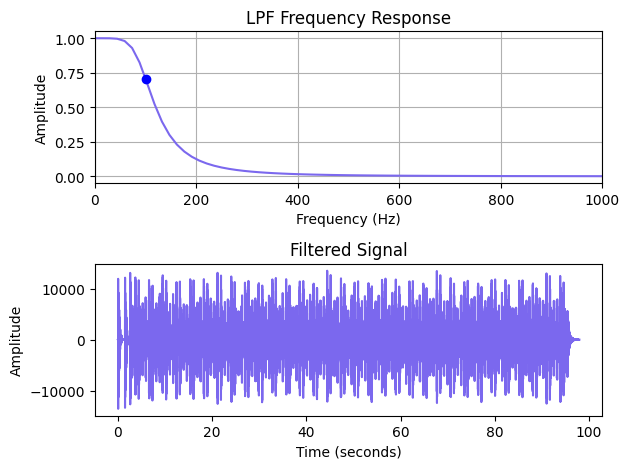

In [14]:
### APPLY LPF AND GRAPH ###

def makeLPF(data, cutoff, fs, order):
  b, a = butter(order, cutoff, fs=fs) # get the coefficients for the lpf
  lpf = lfilter(b, a, data) # apply filter to data
  return lpf

w0 = 100 # cutoff frequency
lpfSignal = makeLPF(signal, w0, fs, 3) # we'll keep order at 3 for now

# calculate filter coefficients outside of function
b, a = butter(3, w0, fs=fs)

### Plot the frequency response.

# h is the frequency response from 0 to 1, w is the frequency
w, h = freqz(b, a, fs=fs, worN=1500) # worN is the number of samples that are graphed

plt.subplot(2, 1, 1)
plt.plot(w, np.abs(h), color="mediumslateblue") # plot the frequency curve
plt.plot(w0, (1/2)*np.sqrt(2), 'bo') # plot the point where the cutoff frequency is
plt.xlim(0, 1000)
plt.title("LPF Frequency Response")
plt.ylabel("Amplitude")
plt.xlabel('Frequency (Hz)')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(secs, lpfSignal, color="mediumslateblue") # plot the filtered audio
plt.title("Filtered Signal")
plt.ylabel("Amplitude")
plt.xlabel("Time (seconds)")
plt.tight_layout()


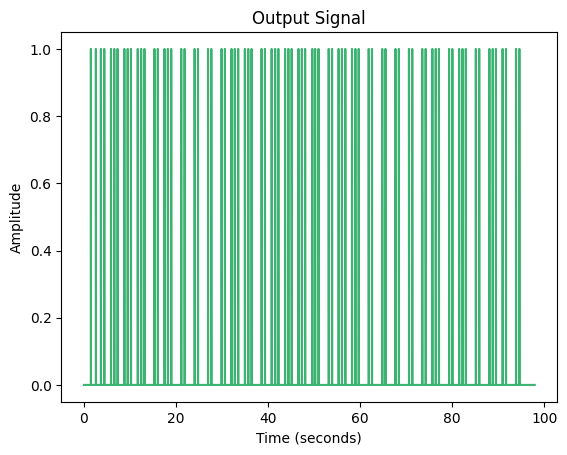

In [27]:
### FILTER LOCAL PEAKS INTO BINARY ARRAY ###

def filterHits(song):
  # define space for array of hits
  hitArr = np.zeros(signal.shape)
  # LPF changed maximum volume, so we'll need to grab it
  maxAmp = song.max()
  # samples per beat = samples/sec / (beats/min * 1min/60sec) = fs / (BPM/60)
  sampPerBeat = fs / (BPM / 60.0)
  lookahead = (int)(sampPerBeat)

  baseIdx, pastIdx = 0, 0 # initialize past and current index for while loop
  endOfSong = False

  # this is where we tell the the program
  while(endOfSong == False):

    # look for the local maximum within a given segment of the song
    lookaheadSegment = song[baseIdx:(baseIdx + lookahead)]
    localMax = lookaheadSegment.max()

    # find where the local maximum is
    maxIdx = baseIdx + lookaheadSegment.argmax()
    # setup the next segment to find the maximum for
    baseIdx = baseIdx + (int)(lookahead/2)

    if (localMax >= (0.6 * maxAmp)) and (maxIdx >= (pastIdx + (int)(fs/4))):
      hitArr[maxIdx] = 1 # only add that maximum if it's loud enough and not too close to the last maximum

    # if there's not enough samples to have another lookahead, you've reached end of the song
    if (baseIdx >= (song.size - lookahead)):
      endOfSong = True # end the while loop

    pastIdx = maxIdx # the latest maximum index is now the previous index

  return hitArr

# call function and save to array
hitArr = filterHits(lpfSignal)

# plot
plt.plot(secs, hitArr, color="mediumseagreen")
#plt.xlim(10, 20) # get a closeup
plt.title("Output Signal")
plt.ylabel("Amplitude")
plt.xlabel("Time (seconds)")
plt.show()


In [9]:
### CONVERT BINARY TO TIMING DIFFERENCE ###

def piInputCoversion(binArr, samp):
  piInArr = []
  count = 0

  for data in binArr:
    # count all of the zeros until you find something else
    if data == 0:
      count = count + 1
    # if not 0, then append the count and reset counter
    else:
      piInArr.append(count)
      count = 0

  # if there's still a count left, append it!
  if count != 0:
    piInArr.append(count)

  # divide all of the counted zeros by the sampling frequency in order to get the time in seconds
  piInArr = [stuff/fs for stuff in piInArr]

  # convert to NumPy array
  npArr = np.array(piInArr)

  return npArr

# call function
beatMap = piInputCoversion(hitArr, fs)
print("Total times you hit the pads for this song:", beatMap.shape[0])


Total times you hit the pads for this song: 82


In [18]:
### TO DELIVER TO BOARD ###

print("These are the deliverables to the board:")
print("Beat map: ", beatMap)
print("Sampling rate: ", fs)

# Saving the beat map to a text file
file = open("generatedMap.txt", "w+")
theStuff = str(beatMap) # copy data
file.write(theStuff) # write to file
file.close()

These are the deliverables to the board:
Beat map:  [1.53267574 1.08426304 1.09061224 0.73580499 1.45281179 0.72108844
 0.71662132 1.4707483  0.72176871 0.71648526 1.470839   0.73839002
 0.7161678  2.1754195  0.73582766 1.45281179 0.72102041 0.73380952
 2.17485261 0.73408163 2.17503401 0.73333333 2.17555556 0.7170068
 2.22909297 0.72678005 1.42401361 0.72163265 0.73414966 1.4539229
 0.73752834 0.7161678  2.17600907 0.73573696 1.45265306 0.75755102
 0.69687075 1.45433107 0.72102041 0.71673469 1.47192744 0.73759637
 0.71580499 1.55764172 0.61811791 0.73585034 2.21020408 0.72678005
 1.42403628 0.72154195 0.73414966 1.45399093 0.73748299 0.71623583
 2.17594104 0.7168254  2.22918367 0.69687075 2.17535147 0.73362812
 2.19274376 0.71569161 2.17580499 0.73589569 1.45263039 0.73736961
 0.70043084 2.1921542  0.71657596 1.47156463 0.73748299 0.71612245
 2.17598639 0.73575964 2.21022676 0.72598639 0.69818594 1.4478458
 0.73410431 2.17496599 0.73337868 3.33605442]
Sampling rate:  44100
